In [1]:
import pandas as pd
import numpy as np
import sklearn

from sklearn import preprocessing, linear_model, metrics, model_selection
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

/Users/skay/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/skay/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
upgraded = pd.read_csv('upgraded_months.csv')
not_upgraded = pd.read_csv('not_upgraded_months.csv')
df = pd.concat([upgraded,not_upgraded], axis=0, join='outer')

In [3]:
df.isnull().sum()

account_id                 0
year_month_run             0
year_month_won             0
year_month_upgraded    88499
upgraded_boolean           0
age_in_months              0
pre_upgrade_plan           0
post_upgrade_plan      88499
upgrade_levels             0
num_agents                 0
mrr_delta                 60
num_trig                   3
num_automations            3
num_tags                   3
num_macros                 3
num_groups                56
num_orgs                  56
num_fields                56
enabled_HC                 0
enabled_redaction          0
enabled_insights       77945
enabled_talk               0
enabled_widget             0
enabled_csat               0
enabled_hours              0
enabled_slas               0
enabled_HCcode         34189
enabled_community      38582
num_apps                   0
num_tix_solved         12051
dtype: int64

In [4]:
df = df.fillna(0)

In [5]:
print upgraded.shape
print not_upgraded.shape
print df.shape

(5180, 30)
(88499, 30)
(93679, 30)


In [6]:
print df.columns 

Index([u'account_id', u'year_month_run', u'year_month_won',
       u'year_month_upgraded', u'upgraded_boolean', u'age_in_months',
       u'pre_upgrade_plan', u'post_upgrade_plan', u'upgrade_levels',
       u'num_agents', u'mrr_delta', u'num_trig', u'num_automations',
       u'num_tags', u'num_macros', u'num_groups', u'num_orgs', u'num_fields',
       u'enabled_HC', u'enabled_redaction', u'enabled_insights',
       u'enabled_talk', u'enabled_widget', u'enabled_csat', u'enabled_hours',
       u'enabled_slas', u'enabled_HCcode', u'enabled_community', u'num_apps',
       u'num_tix_solved'],
      dtype='object')


In [7]:
df =  df.sort_values(by=['account_id', 'year_month_run'], axis = 0, ascending=[True, True])
df = df.reset_index(drop = True)

In [8]:
df = df.drop(['year_month_won','year_month_upgraded','post_upgrade_plan','upgrade_levels','mrr_delta'], axis = 1)

In [11]:
#CREATE MONTH OVER MONTH CHANGE RATIOS FOR ALL CONTINUOUS NUMERIC FEATURES
features = df.columns.tolist()
f1 = pd.DataFrame(features) 
continuous_features = f1[f1[0].str.contains("num_")][0].tolist()
continuous_features

['num_agents',
 'num_trig',
 'num_automations',
 'num_tags',
 'num_macros',
 'num_groups',
 'num_orgs',
 'num_fields',
 'num_apps',
 'num_tix_solved']

In [12]:
#CREATE MONTH OVER MONTH CHANGE RATIOS FOR ALL CONTINUOUS NUMERIC FEATURES (cont...)
continuous_features = ['num_tix_solved']
for i in continuous_features:
    f = '%change_' + str(i)
    df[f] = ''
    n = 0
    for a in df.account_id.unique(): 
        b = 0
        while b < len(df[df.account_id == a]):
            if (b-1 < 0) | (n-1 < 0): 
                df.loc[n,f] = "null" 
            else: 
                df.loc[n,f] = (df.loc[n,i] - df.loc[n-1,i])/ df.loc[n-1,i]
            b = b + 1
            n = n + 1
print df

       account_id  year_month_run  upgraded_boolean  age_in_months  \
0           70796          201601                 0              1   
1           70796          201602                 0              2   
2           70796          201603                 0              3   
3           70796          201604                 0              4   
4           70796          201605                 0              5   
5           70796          201606                 0              6   
6           70796          201607                 0              7   
7           70796          201608                 0              8   
8           70796          201609                 0              9   
9           70796          201610                 0             10   
10          70796          201611                 0             11   
11          70804          201610                 0              1   
12          70804          201611                 0              2   
13         119516   

In [13]:
len(df.account_id.unique())

15827

In [14]:
df = df.dropna()

In [15]:
## REMOVE ALL ENTERPRISE PLANS (since it's the highest plan, no upgrading)
df = df[(df.pre_upgrade_plan != 0) & (df.pre_upgrade_plan != 'Enterprise Elite') & (df.pre_upgrade_plan != 'Enterprise') & (df.pre_upgrade_plan != 'Enterprise (Legacy)')]

In [16]:
#CREATE DUMMIES FOR THE PRE-UPGRADE PLAN AND DROP THE ORIGINAL COLUMN
pre_upgrade_plan_df = pd.get_dummies(df.pre_upgrade_plan, prefix = None)
df = pd.concat([df, pre_upgrade_plan_df], axis = 1)
df = df.drop('pre_upgrade_plan', axis = 1)

In [17]:
df.upgraded_boolean.value_counts()

0    85228
1     2517
Name: upgraded_boolean, dtype: int64

In [18]:
2517/85228.

0.029532547988923828

In [201]:
len(df.account_id.unique())

15012

In [19]:
c = df.upgraded_boolean
X = df[df.drop('upgraded_boolean', axis=1).columns.tolist()]

In [203]:
#NEED TO TRY TO SPLIT THE TRAIN/TEST DATA AT THE ACCOUNT LEVEL... dont want accounts getting split.

In [58]:
train_X, test_X, train_c, test_c = sklearn.model_selection.train_test_split(X, c, train_size = .5)

In [59]:
model = linear_model.LogisticRegression(class_weight='balanced').fit(train_X, train_c)

print model.coef_
print model.intercept_

[[ -8.90994262e-07   5.00952502e-06  -1.37504968e-01  -6.19645060e-04
   -2.47390009e-02  -9.65210591e-03  -3.88189680e-07   6.17603134e-03
   -5.75549596e-03   7.33100197e-07   2.68883258e-02   1.06033414e-01
   -2.84437098e-02  -1.39955555e-01   1.73975048e-01   1.71974692e-01
   -1.49390590e-01   6.82470016e-02  -5.39724541e-03   4.21041994e-02
    8.71691415e-02   6.67070278e-02   1.98789222e-06   6.25653933e-01
   -7.96043218e-02  -4.51875698e-01  -1.20755619e-02  -1.08318996e-01
    2.62083838e-02]]
[ -1.22610962e-05]


In [60]:
model.score(train_X, train_c)

0.62019055433989789

## calculate the log odds

In [61]:
logit_hat_Upgrade = model.intercept_ + (train_X * model.coef_[0]).sum(axis = 1)

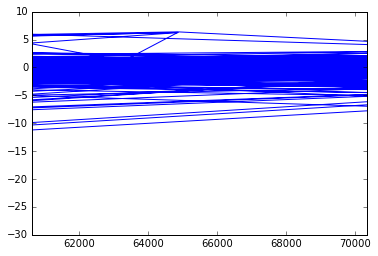

In [62]:
logit_hat_Upgrade.plot()

In [63]:
((logit_hat_Upgrade >= 0) == (train_c == 1)).sum()

27209

In [64]:
((logit_hat_Upgrade >= 0) == (train_c == 1)).mean()

0.62019055433989789

## convert log odds to odds ratios by taking the exponent

In [65]:
odds_hat_Upgrade = np.exp(logit_hat_Upgrade)

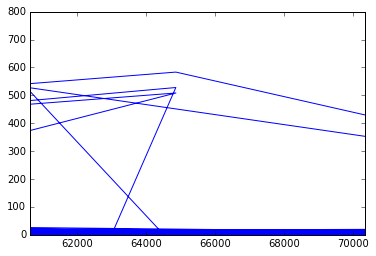

In [66]:
odds_hat_Upgrade.plot()

In [67]:
((odds_hat_Upgrade >= 1) == (train_c == 1)).sum()

27209

In [68]:
((odds_hat_Upgrade >= 1) == (train_c == 1)).mean()

0.62019055433989789

## convert odds ratio to probability scores

In [69]:
p_hat_Upgrade = odds_hat_Upgrade / (1 + odds_hat_Upgrade)

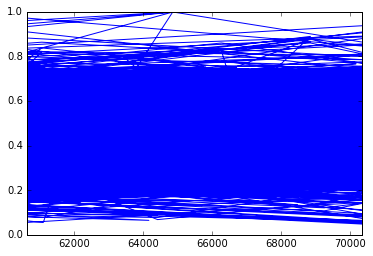

In [70]:
p_hat_Upgrade.plot()

In [71]:
((p_hat_Upgrade >= .5) == (train_c == 1)).sum()

27209

In [72]:
((p_hat_Upgrade >= .5) == (train_c == 1)).mean()

0.62019055433989789

In [73]:
c_hat_Upgrade = p_hat_Upgrade.round()

In [74]:
pd.crosstab(c_hat_Upgrade,
    c,
    rownames = ['Predicted'],
    colnames = ['Actual'])

#how does this look when aggregated at the account level?
#grab all the account ids from 1:1 and see how many times they appear in 0:1 

Actual,0,1
Predicted,,
0,26393,404
1,16259,816


43872

In [188]:
c_hat_Upgrade_df = c_hat_Upgrade.to_frame('predicted_class')

In [189]:
new_df = pd.concat([train_X, train_c, c_hat_Upgrade_df], axis=1)

In [190]:
new_df.head()

,account_id,year_month_run,age_in_months,num_agents,num_trig,num_automations,num_tags,num_macros,num_groups,num_orgs,...,num_apps,num_tix_solved,Essential,Plus,Professional,Regular,Starter,Team,upgraded_boolean,predicted_class
60650,952704,201606,2,2,3,1,7,4,2,4,...,0,17,0,0,0,0,0,1,0,1
35258,882396,201604,3,1,5,1,2,4,1,1,...,0,1,1,0,0,0,0,0,0,1
41396,899966,201611,10,6,9,1,11,4,3,1,...,0,204,0,0,0,0,0,1,0,0
40442,898211,201603,1,1,6,1,401,19,1,1,...,0,1950,1,0,0,0,0,0,0,1
63997,962759,201610,6,1,6,1,0,31,1,2,...,1,0,1,0,0,0,0,0,0,1


In [192]:
predict_1_actual_1 = new_df[(new_df.upgraded_boolean == 1) & (new_df.predicted_class == 1)]

In [194]:
predict_1_actual_0 = new_df[(new_df.upgraded_boolean == 0) & (new_df.predicted_class == 1)]

In [197]:
p1_a1 = predict_1_actual_1.account_id.unique()
print "p1_a1 accounts count", len(p1_a1)
p1_a0 = predict_1_actual_0.account_id.unique()
print "p1_a0 accounts count", len(p1_a0)

p1_a1 accounts count 663
p1_a0 accounts count 7736


In [199]:
len(set(p1_a1) & set(p1_a0))

238

In [143]:
max_yrMth = new_df.groupby(['account_id'], sort=False)['year_month_run'].max()

In [163]:
yr = max_yrMth.to_frame()

In [169]:
yr = yr.reset_index()

In [170]:
new_df.to_csv("new_df.csv")